**1. Android Marketten Yorumları Çekme**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install google-play-scraper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
## Burada doğru uygulamayı alabiliyor muyum diye kontrol ediyorum.

from google_play_scraper import app

# Uygulamanın uzantısı. Web adresinden aldım
app_package = 'com.denizbank.mobildeniz&gl=TR'

result = app(app_package)

# Başlıklar :
app_title = result['title']
developer = result['developer']
rating = result['score']
reviews = result['reviews']

# Yazdırıyorum :
print("Uygulama Adı:", app_title)
print("Geliştirici:", developer)
print("Derecelendirme:", rating)
print("Yorumlar:", reviews)

Uygulama Adı: MobilDeniz
Geliştirici: DenizBank
Derecelendirme: 4.2514224
Yorumlar: 19732


In [ ]:
## Tüm yorumları yorumlar.txt adlı bir text dosyasına atıyorum.

from google_play_scraper import reviews_all

app_package = 'com.denizbank.mobildeniz'

# Uygulama yorumlarını çekmek için reviews_all()
result = reviews_all(
    app_package,
    lang='tr',  # Türkçe yorumları almak için 'tr'
)

# Elde edilen yorumları metin dosyasına yazdırma:
with open("yorumlar.txt", "w", encoding="utf-8") as file:
    for review in result:
        comment = review['content']
        file.write(comment + "\n")

KeyboardInterrupt: ignored

**2. Veri Ön İşleme Adı**

In [ ]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

In [ ]:
filterwarnings('ignore') ## Bazı hataların önüne geçmek için, ignoreladım.
pd.set_option('display.max_columns', None) ## Tüm kolonları gösterdim.
pd.set_option('display.width', 200) ## Max genişliği 200 aldım. Rahat gözüksün diye.
pd.set_option('display.float_format', lambda x: '%.2f' % x) ## virgülden sonra 2 basamak göstermesi için.

In [ ]:
AppFile = "/content/drive/MyDrive/DenizBank Mobil Yorumlar/yorumlar.txt"

# Metin dosyasını satır satır okuyarak verileri elde edin
with open(AppFile, "r", encoding="utf-8") as file:
    comments = [line.strip() for line in file]

# Verileri bir DataFrame'e dönüştürün
df = pd.DataFrame({"Yorumlar": comments})

print(df)

                                               Yorumlar
0     Normalde güzel çalışıyordu ama iki gündür açıl...
1     Mobil veri olayı yüzünden anlaşmamı kestim bu ...
2                               Mobil giriş yapamıyorum
3                                    Mobil deniz 💯 puan
4                                 Gayet iyi kullanışlı.
...                                                 ...
4993                                 Güzel bir oygulama
4994                                    Banka neden var
4995                           Beş para etmez uygulama.
4996  Berbat hatta berbat ötesi daha ileri ve teknik...
4997  Bu şekilde yeni güncellemeniz hiç hoşuma gitme...

[4998 rows x 1 columns]


In [ ]:
# Bütün yorumları küçük harf yapıyorum.
# İleride kullanacağım teknikler büyük küçük harf duyarlılığına sahip. Bu yüzden tüm kelimeleri küçük hafli yapıyorum.
df['Yorumlar'] = df['Yorumlar'].str.lower()

In [ ]:
df['Yorumlar'] = df['Yorumlar'].str.replace('[^\w\s]', '') ## Noktalama işaretlerini boşluk ile değiştiriyorum.

## [^\w\s] bu ifade noktalama işaretlerini seçer.

In [ ]:
df = df.drop(index=0) # Kısaltmalar kullanılan saçma bir yorum olduğu için kaldırdım.

In [ ]:
df

,Yorumlar
1,mobil veri olayı yüzünden anlaşmamı kestim bu ...
2,mobil giriş yapamıyorum
3,mobil deniz puan
4,gayet iyi kullanışlı
5,25yıldır vazgeçemediğim bankam
...,...
4993,güzel bir oygulama
4994,banka neden var
4995,beş para etmez uygulama
4996,berbat hatta berbat ötesi daha ileri ve teknik...


In [ ]:
## Duygu analiz sonuçlarımı kötü etkilediği için bu dört aşamayı yapmayacağım ama kodumda yer alacak. İleride kullanılması gerekilebilir.

# df['Yorumlar'] = df['Yorumlar'].str.replace('[\d]', '') ## [\d] metindeki sayıları seçer.

# sw = stopwords.words('turkish') ## Stopwordsleri sw değişkenine atadım. Nedir bu stopwordsler; "acaba, ama, birkaç, diye, eğer, gibi, hep, ki, kez" gibi kelimelerdir.
# df['Yorumlar'] = df['Yorumlar'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
## split() metodunun ön tanımlı dğeeri boşluktur. Bu yüzden ekstra bir şey yapmamıza gerek kalmadı.
## x for x in str(x) burada ise metni string olarak alıyorum.
## if x not in sw ile stopwords olanları eliyorum.
## lambda x: " ".join() ile de boşluklara göre birleştiriyorum. Kelimeler arasında boşluk bırakarak birleştirir.

# temp_df = pd.Series(' '.join(df['Yorumlar']).split()).value_counts()
## value_counts() ile kelimeleri saydırdım.
# drops = temp_df[temp_df <= 1] ## Burada metnin içinde bir ve ya daha az geçen kelimeleri yakalıyorum.
## Bu kelimeler ayırt edicilik için pek bir önem arz etmiyor.
# df['Yorumlar'] = df['Yorumlar'].apply(lambda x: " ".join(x for x in str(x).split() if x not in drops))
## 1 yada daha az geçen kelimeleri textten eledim.

# df['Yorumlar'] = df['Yorumlar'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
## Burada kelimeleri köklerine ayırıyorum.

**3. Sentiment Analysis**

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.4 MB/s eta 0:00:00


In [ ]:
## 13dk 56sn
import pandas as pd
from transformers import pipeline

sentiment_analysis_tr = pipeline("sentiment-analysis", model="savasy/bert-base-turkish-sentiment-cased")

data = df[:]

def analyze_sentiment(text):
  result = sentiment_analysis_tr(text)[0]
  label = result['label']
  return label


data['Duygu'] = data["Yorumlar"].apply(analyze_sentiment)

print(data)

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


                                               Yorumlar     Duygu
1     mobil veri olayı yüzünden anlaşmamı kestim bu ...  negative
2                               mobil giriş yapamıyorum  negative
3                                     mobil deniz  puan  positive
4                                  gayet iyi kullanışlı  negative
5                        25yıldır vazgeçemediğim bankam  positive
...                                                 ...       ...
4993                                 güzel bir oygulama  positive
4994                                    banka neden var  negative
4995                            beş para etmez uygulama  negative
4996  berbat hatta berbat ötesi daha ileri ve teknik...  negative
4997  bu şekilde yeni güncellemeniz hiç hoşuma gitme...  negative

[4997 rows x 2 columns]


In [ ]:
data.to_csv("/content/drive/MyDrive/DenizBank Mobil Yorumlar/Yorumlar2.txt", sep='\t', index=False)

In [ ]:
# DataFrame'deki "etiket" sütununu kullanarak pozitif ve negatif yorumları sayma
yorumlar = data['Yorumlar']
etiketler = data['Duygu']

# Pozitif yorumların sayısı
pozitif_yorumlar = yorumlar[etiketler == 'positive']
pozitif_yorum_sayisi = len(pozitif_yorumlar)

# Negatif yorumların sayısı
negatif_yorumlar = yorumlar[etiketler == 'negative']
negatif_yorum_sayisi = len(negatif_yorumlar)

# Sonuçları yazdırma
print("Pozitif yorum sayısı:", pozitif_yorum_sayisi)
print("Negatif yorum sayısı:", negatif_yorum_sayisi)


Pozitif yorum sayısı: 1728
Negatif yorum sayısı: 3269


In [ ]:
from collections import Counter

# Negatif yorumlardaki en çok tekrar eden satırı bulma
en_cok_tekrar_eden_satir_neg = Counter(negatif_yorumlar).most_common(1)
en_cok_tekrar_eden_satir_neg = en_cok_tekrar_eden_satir_neg[0][0]

# Pozitif yorumlardaki en çok tekrar eden satırı bulma
en_cok_tekrar_eden_satir_pos = Counter(pozitif_yorumlar).most_common(1)
en_cok_tekrar_eden_satir_pos = en_cok_tekrar_eden_satir_pos[0][0]

# Sonuçları yazdırma
print("Negatif yorumlardaki en çok tekrar eden satır:")
print(en_cok_tekrar_eden_satir_neg)
print("Pozitif yorumlardaki en çok tekrar eden satır:")
print(en_cok_tekrar_eden_satir_pos)


Negatif yorumlardaki en çok tekrar eden satır:
berbat
Pozitif yorumlardaki en çok tekrar eden satır:
güzel


In [ ]:
from collections import Counter

# Negatif yorumlardaki en çok tekrar eden satır ve frekansı
tekrar_sayilari_neg = Counter(negatif_yorumlar)
en_cok_gecen_10_satir_neg = tekrar_sayilari_neg.most_common(10)
neg_10 = pd.DataFrame(en_cok_gecen_10_satir_neg, columns = ['Yorum', 'Adet']) # İleride kullanmak için df 'e çevirdim.

# Pozitif yorumlardaki en çok tekrar eden satır ve frekansı
tekrar_sayilari_pos = Counter(pozitif_yorumlar)
en_cok_gecen_10_satir_pos = tekrar_sayilari_pos.most_common(10)
pos_10 = pd.DataFrame(en_cok_gecen_10_satir_pos, columns = ['Yorum', 'Adet'])

# Sonuçları yazdırma
print("Negatif yorumlardaki en çok geçen ilk 10 satır: ", en_cok_gecen_10_satir_neg)
print("Pozitif yorumlardaki en çok geçen ilk 10 satır: ", en_cok_gecen_10_satir_pos)

Negatif yorumlardaki en çok geçen ilk 10 satır:  [('berbat', 20), ('uygulama açılmıyor', 11), ('açılmıyor', 9), ('çok kötü', 8), ('çalışmıyor', 6), ('berbat bir uygulama', 5), ('memnunum', 5), ('uygulamaya giremiyorum', 4), ('çok yavaş', 4), ('uygulama inmiyor', 4)]
Pozitif yorumlardaki en çok geçen ilk 10 satır:  [('güzel', 75), ('süper', 63), ('', 63), ('harika', 59), ('iyi', 56), ('çok iyi', 38), ('çok güzel', 34), ('mükemmel', 31), ('guzel', 27), ('super', 24)]


In [ ]:
import nltk
nltk.download('stopwords') # Stopwords fonksiyonu için.
nltk.download('wordnet') # Lemmatize fonksiyonu için.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
sw = stopwords.words('turkish') ## Stopwordsleri sw değişkenine atadım. Nedir bu stopwordsler; "acaba, ama, birkaç, diye, eğer, gibi, hep, ki, kez" gibi kelimelerdir.
negatif_yorumlar = negatif_yorumlar.apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
pozitif_yorumlar = pozitif_yorumlar.apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
## split() metodunun ön tanımlı dğeeri boşluktur. Bu yüzden ekstra bir şey yapmamıza gerek kalmadı.
## x for x in str(x) burada ise metni string olarak alıyorum.
## if x not in sw ile stopwords olanları eliyorum.
## lambda x: " ".join() ile de boşluklara göre birleştiriyorum. Kelimeler arasında boşluk bırakarak birleştirir.

In [ ]:
negatif_yorumlar = negatif_yorumlar.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
pozitif_yorumlar = pozitif_yorumlar.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
## Burada kelimeleri köklerine ayırıyorum.

In [ ]:
temp_df_neg = pd.Series(' '.join(negatif_yorumlar).split()).value_counts()
temp_df_pos = pd.Series(' '.join(pozitif_yorumlar).split()).value_counts()
## value_counts() ile kelimeleri saydırdım.

print(temp_df_neg)
print(temp_df_pos)

bir              1244
uygulama          771
mobil             578
müşteri           475
banka             403
                 ... 
istedigimi          1
aradığınız          1
oluruz              1
getirirseniz        1
kullanışlıydı       1
Length: 12523, dtype: int64
güzel                              335
iyi                                230
bir                                217
uygulama                           198
harika                             111
                                  ... 
2wwww2wwww2                          1
aaawawaa2www2wawawaw22www22222w      1
belediyesi                           1
beyoğlu                              1
oygulama                             1
Length: 2348, dtype: int64


In [ ]:
# En çok geçen ilk 10 kelimeyi yeni birer listeye atadım.
temp_df_neg_fnl = temp_df_neg[:10]
temp_df_pos_fnl = temp_df_pos[:10]

print(temp_df_neg_fnl)
print(temp_df_pos_fnl)

bir         1244
uygulama     771
mobil        578
müşteri      475
banka        403
yok          388
giriş        356
kredi        320
var          285
kadar        274
dtype: int64
güzel        335
iyi          230
bir          217
uygulama     198
harika       111
süper        109
deniz        102
banka         96
ederim        92
denizbank     86
dtype: int64


**4. Text Visualization**

In [ ]:
## Datam toplamda 19.536 satırdan oluşuyor ve kelime bazlı saydırdığım için çok büyük bir data ortaya çıkıyor. Haliyle uygulama çöküyor. Bu yüzden aşağıda datadan bir örneklem alıp onu görselleştireceğim.

#pos_10 = en_cok_gecen_10_satir_pos
#neg_10 = en_cok_gecen_10_satir_neg

#tf = df2["Yorumlar"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
## sum(axis=0) satır bazında ilgili kelimelerin frekanslarını toplamamızı sağlar.
## reset_index() okunabilir bir formata getirmek için indexlerini resetledim.

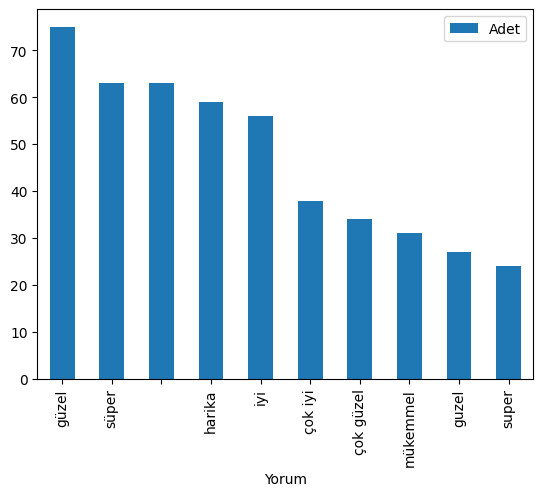

In [ ]:
pos_10.plot.bar(x="Yorum", y="Adet") ## x ve y eksenlerini verdim.
plt.show()

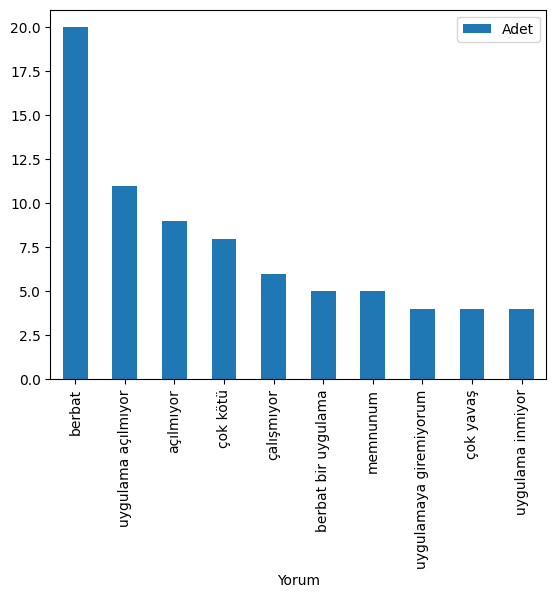

In [ ]:
neg_10.plot.bar(x="Yorum", y="Adet") ## x ve y eksenlerini verdim.
plt.show()

**5. Machine Learning Modeling**

In [ ]:
data["Duygu"] = LabelEncoder().fit_transform(data["Duygu"])
## Kullanacak olduğum makine öğrenmesinin anlayacağı türden bir binary bağımlı değişkeni oluşturmuş oldum.

In [ ]:
data

,Yorumlar,Duygu
1,mobil veri olayı yüzünden anlaşmamı kestim bu ...,0
2,mobil giriş yapamıyorum,0
3,mobil deniz puan,1
4,gayet iyi kullanışlı,0
5,25yıldır vazgeçemediğim bankam,1
...,...,...
4993,güzel bir oygulama,1
4994,banka neden var,0
4995,beş para etmez uygulama,0
4996,berbat hatta berbat ötesi daha ileri ve teknik...,0


In [ ]:
y = data["Duygu"] ## Bağımlı değişkenimiz.
X = data["Yorumlar"] ## Bağımsız değişkenimiz.

**5.1 Count Vector**




*   Elimizdeki texti (metni) öyle bir hale getirmeliyiz ki lineer cebir dünyasında işlenebilir bir hale gelsin.
Bunun için;
*   Count Vectors   : Frekans temsiller
*   TF-IDF Vectors  : Normalize edilmiş frekans temsiller


*   Word Embeddings (Word2Vec, Glove, BERT vs)





**5.2 TF_IDF**


*   CountVector 'ün ortaya çıkarabileceği bazı yanlılıkları gidermek adına; normalize edilmiş, standartlaştırılmış bir kelime vektörü oluşturma yöntemidir.
*   Kelimelerin dökümanlarda geçme frekansını ve kelimelerin tüm corpusta geçme frekansları odağında bir standartlaştırma işlemi yapılır.



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_word_vectorizer = TfidfVectorizer()

X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X) ## Word model

tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2,5))
X_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(X) ## ngram model

# ngram_range=(2,4) şu anlama gelmektedir:
# 2-gram'lar: "Bu ürün", "ürün gerçekten", "gerçekten çok", "çok kullanışlı", "kullanışlı ve", "ve kaliteli"
# 3-gram'lar: "Bu ürün gerçekten", "ürün gerçekten çok", "gerçekten çok kullanışlı", "çok kullanışlı ve", "kullanışlı ve kaliteli"
# 4-gram'lar: "Bu ürün gerçekten çok", "ürün gerçekten çok kullanışlı", "gerçekten çok kullanışlı ve", "çok kullanışlı ve kaliteli"
# yani 2li 3lü ve 4lü ngram modelleri oluşturur.

**5.3 Logistic Regression**

In [ ]:
log_model = LogisticRegression().fit(X_tf_idf_word, y) ## Bağımsız değişken olarak son fit ettiğimiz word vektörümüzü verdim.

In [ ]:
cross_val_score(log_model,
                X_tf_idf_ngram,
                y,
                scoring="accuracy",
                cv=10).mean() ## 10 katlı çapraz doğrulama yaparak modelin doğruluğunu (scoring="accuracy") test ettim.

## ngram model düşük başarı elde etti.

0.7298396793587173

In [ ]:
cross_val_score(log_model,
                X_tf_idf_word,
                y,
                scoring="accuracy",
                cv=10).mean() ## 10 katlı çapraz doğrulama yaparak modelin doğruluğunu (scoring="accuracy") test ettim.

0.874524248496994

In [ ]:
while True:
  yorum = input("\n\nÇıkmak için 'çıkış' yazınız. \nYorumunuzu girin: ")
  if yorum == 'çıkış':
    break

  yeni_yorum = pd.Series([yorum])
  yeni_yorum = TfidfVectorizer().fit(X).transform(yeni_yorum)
  tahmin = log_model.predict(yeni_yorum)

  if tahmin == 0:
    tahmin_etiketi = "negatif"
  else:
    tahmin_etiketi = "pozitif"

  print("Yorum :", yorum, "-->Tahmin :", tahmin_etiketi)


print("Çıkış yapıldı.")

**5.4 Random Forest**

In [ ]:
##count model
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(X)
rf_model_1 = RandomForestClassifier().fit(X_count, y)
cross_val_score(rf_model_1, X_count, y, cv=10, n_jobs=-1).mean() ##n_jobs=-1 bütün işlemcileri kullan demektir.

0.897141482965932

In [ ]:
##word model
rf_model_2 = RandomForestClassifier().fit(X_tf_idf_word, y)
cross_val_score(rf_model_2, X_count, y, cv=10, n_jobs=-1).mean()

0.8931327327327327

In [ ]:
## ngram model
rf_model = RandomForestClassifier().fit(X_tf_idf_ngram, y)
cross_val_score(rf_model, X_count, y, cv=10, n_jobs=-1).mean()

0.8975378757515029

In [ ]:
rf_model = RandomForestClassifier(random_state=17) ## random_state=17 ile her defasında aynı sonucu alırız.
## Sayıyı rastgele yazıyoruz.

In [ ]:
rf_params = {"max_depth": [5, 8, None], ## max derinlik
             "max_features": [5, 7, "auto"], ## bölünmelerde göz önünde bulundurulacak özellik, değişken sayısı
             "min_samples_split": [2, 5, 8, 20], ## bölünmelerde bir yaprakta ne kadar örnek olması gerektiğinin parametresi
             "n_estimators": [100, 200, 500]} ## kaç tane ağaç fit edileceğini ifade eder

In [ ]:
## Başarının değerlendirilmesi için; 1 saat 46dk 30sn
rf_best_grid = GridSearchCV(rf_model,
                            rf_params,
                            cv=10,
                            n_jobs=-1,
                            verbose=True).fit(X_count, y) ## verbose=True raporlama almamızı sağlar.

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


In [ ]:
rf_best_grid.best_params_ ## Yukarıda en iyi sonuç veren parametreleri girdik.

{'max_depth': None,
 'max_features': 5,
 'min_samples_split': 2,
 'n_estimators': 500}

In [ ]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_count, y)
## **rf_best_grid.best_params_ iki yıldız ile yazarsak, içindeki key ve valueları al demek olur.

In [ ]:
# 3 satır yukarıdaki optimize işlemim çok uzun sürdüğü için onun sonuçlarını elle burada atıyorum:
rf_params = {"max_depth": None, ## max derinlik
             "max_features": 5, ## bölünmelerde göz önünde bulundurulacak özellik, değişken sayısı
             "min_samples_split": 2, ## bölünmelerde bir yaprakta ne kadar örnek olması gerektiğinin parametresi
             "n_estimators": 500}

rf_final = rf_model.set_params(**rf_params, random_state=17).fit(X_count, y)

In [ ]:
## Son kez skorumuza bakalım.
cross_val_score(rf_final, X_count, y, cv=5, n_jobs=-1).mean()

0.9023385385385385

In [ ]:
while True:
  yorum = input("\n\nÇıkmak için 'çıkış' yazınız. \nYorumunuzu girin: ")
  if yorum == 'çıkış':
    break

  yeni_yorum = pd.Series([yorum])
  yeni_yorum = TfidfVectorizer().fit(X).transform(yeni_yorum)
  tahmin = rf_final.predict(yeni_yorum)

  if tahmin == 0:
    tahmin_etiketi = "negatif"
  else:
    tahmin_etiketi = "pozitif"

  print("Yorum :", yorum, "-->Tahmin :", tahmin_etiketi)


print("Çıkış yapıldı.")

In [ ]:
## Yaptığım hatalı eklemeleri sildim.

import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/DenizBank Mobil Yorumlar/Yorumlar2.txt', delimiter='\t')
data = data[:-1]

data

,Yorumlar,Duygu
0,mobil veri olayı yüzünden anlaşmamı kestim bu ...,0
1,mobil giriş yapamıyorum,0
2,mobil deniz puan,1
3,gayet iyi kullanışlı,0
4,25yıldır vazgeçemediğim bankam,1
...,...,...
4929,güzel bir oygulama,1
4930,banka neden var,0
4931,beş para etmez uygulama,0
4932,berbat hatta berbat ötesi daha ileri ve teknik...,0


# **MODELİN TOPARLANMASI**
**FİNAL**

Bu aşamadan önce verileri çekip, ön işlemlerden geçirdim ki sağlık bir veri seti oluşsun. Tabi bunun için önce veri setini iyice anlamaya çalıştım. Ardından üzerinde bir çok denemeler yaparak işlenmeye en uygun hale getirdim. Burada bir sınıflandırma yaptığım için önce Logistic Regression sonra da Random Forest modellerini kurarak denedim. Başta elde ettiğim başarı oranı düşüktü bu yüzden geri gidip yaptığım bazı işlemleri iptal ettim, bazı yeni eklemeler yaptım. Ardından denediğimde Logistic Regression 'da %87, Random Forest 'ta %89 başarım elde ettim. Hiper parametre optimizasyonunu uyguladıktan sonra %90 'a çıkarabildim. Daha fazla başarım elde etmek için Hiper Parametre Optimizasyonuna biraz daha eğilinilebilinir fakat colab çok yavaş işlem yapıyor. Yaklaşık 2 saatte aldığım için sonuçları bu aşamada pek bir deneme yapamadım. Haliyle başarıyı arttırmak için artık veri setine yeni değişkenler eklemeli ve doğru sınıflandırma yapmalıyım diye düşünüyorum bu yüzden de modelimi programladım. Aşağı da detayları inceleyebilirsiniz.

Duygu sınıflandırmasını kullandığım kaynak : https://github.com/savasy/Turkish-Bert-NLP-Pipeline

Programı hızlı bir şekilde çalıştırabilmek için bilerek iki ayrı kod bloğuna böldüm. İlk kısım olan makine öğrenmesi kısmı 1 dk 10 sn civarında sonuçlanıyor.
İkinci kısım olan programlama kısmında çok fazla kez deneme yapmam gerektiği için her defasında modeli tekrar tekrar kurmasını beklemek istemedim.

Önemli Not : Programı çalıştırıp yeni yorumlar girerseniz, çıkış yazıp programı kapattığınızda yazdığınız tüm yeni yorumlar içeriye alınmaktadır. Bu şekilde sürekli büyüyen bir veri setini oluşturabildim. Bu kısım bence çok çok önemli.
Veri seti sürekli büyüdüğü için ilk blok olan modelleme kısmını her yeni yapılan kayıttan sonra tekrar çalıştırılmalıdır.

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re

data = pd.read_csv('/content/drive/MyDrive/DenizBank Mobil Yorumlar/Yorumlar2.txt', sep='\t').dropna()

data["Duygu"] = LabelEncoder().fit_transform(data["Duygu"])

y = data["Duygu"] ## Bağımlı değişkenimiz.
X = data["Yorumlar"] ## Bağımsız değişkenimiz.

vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(X)

tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2,5))
X_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(X)

rf_model = RandomForestClassifier().fit(X_tf_idf_ngram, y)
rf_params = {"max_depth": None,
             "max_features": 5,
             "min_samples_split": 2,
             "n_estimators": 500}

rf_final = rf_model.set_params(**rf_params).fit(X_count, y)


In [ ]:
print("\nÇıkmak için 'çıkış' yazınız.")
print("\nEğer tahmin yanlışsa '0' yazın. \nDoğruysa '1' yazın: \n")

yeni_veriler = []

while True:
  print("------------------------")
  print("Yorumunuzu girin : ")
  yorum = input()
  if yorum == 'çıkış':
    break

  yorum = yorum.lower()
  yorum = re.sub(r'[^\w\s]', '', yorum)

  yeni_yorum = pd.Series([yorum])
  yeni_yorum_count = vectorizer.transform(yeni_yorum)
  tahmin = rf_final.predict(X_count[-1, :])

  if tahmin == 0:
    tahmin_etiketi = "negatif"
  else:
    tahmin_etiketi = "pozitif"

  print("-->Tahmin :", tahmin_etiketi)
  # Tahmin yanlışsa düzeltme yapılacak.
  print("Tahmin Doğru mu? (1/0)")
  duzeltme = 1
  duzeltme = int(input())
  if duzeltme == 0:
      tahmin = 1 - tahmin ## tahminin tersini alarak düzeltmiş olucaz.
      print("\nDüzeltme yapıldı.\n")
      if tahmin == 0:
          tahmin_etiketi = "negatif"
      else:
          tahmin_etiketi = "pozitif"
      print("Yorum: ", yorum, "--> Tahmin: ", tahmin_etiketi)


  yeni_veri = {"Yorumlar": yorum, "Duygu": tahmin}
  yeni_veriler.append(yeni_veri)

  # Yeni yorumu veri setine yükleme;
  #yeni_veri = pd.DataFrame.from_dict({"Yorumlar": [yorum], "Duygu": tahmin})
  #data = pd.concat([data, yeni_veri], ignore_index=True)


  # Veri kümesinin de güncellenmesi gerek;
  y = data["Duygu"] ## Bağımlı değişkenimiz.
  X = data["Yorumlar"] ## Bağımsız değişkenimiz.
  X_count = vectorizer.fit_transform(X)



  print("------------------------")


print("Çıkış yapıldı.")

yeni_veriler_df = pd.DataFrame(yeni_veriler)
yeni_veriler_df["Duygu"] = yeni_veriler_df["Duygu"].astype(int)  # Duygu sütununu integer tipine dönüştürme
data = pd.concat([data, yeni_veriler_df], ignore_index=True)

# Güncellenmiş veri kümesini dosyamıza yazdırıyoruz ki datalarımız büyüsün, modelimiz doğru tahminlerle gelişsin.
data.to_csv('/content/drive/MyDrive/DenizBank Mobil Yorumlar/Yorumlar2.txt', index=False, sep='\t')

print("Veri kümesi güncellendi.")


Çıkmak için 'çıkış' yazınız.

Eğer tahmin yanlışsa '0' yazın. 
Doğruysa '1' yazın: 

------------------------
Yorumunuzu girin : 
harikamsı
-->Tahmin : negatif
Tahmin Doğru mu? (1/0)
0

Düzeltme yapıldı.

Yorum:  harikamsı --> Tahmin:  pozitif
------------------------
------------------------
Yorumunuzu girin : 
çıkış
Çıkış yapıldı.
Veri kümesi güncellendi.


In [ ]:
data

,Yorumlar,Duygu
0,mobil veri olayı yüzünden anlaşmamı kestim bu ...,0
1,mobil giriş yapamıyorum,0
2,mobil deniz puan,1
3,gayet iyi kullanışlı,0
4,25yıldır vazgeçemediğim bankam,1
...,...,...
4991,harikamsı,1
4992,harikamsı olmuş,1
4993,muhteşem gözüküyor,1
4994,leş gibi,0


In [ ]:
## Burada yaptığım hatalı eklemeleri siliyordum ki veri setini bozmadan tekrar tekrar deneyebileyim.

data = pd.read_csv('/content/drive/MyDrive/DenizBank Mobil Yorumlar/Yorumlar2.txt', delimiter='\t')
data = data[:-4]

data

,Yorumlar,Duygu
0,mobil veri olayı yüzünden anlaşmamı kestim bu ...,0
1,mobil giriş yapamıyorum,0
2,mobil deniz puan,1
3,gayet iyi kullanışlı,0
4,25yıldır vazgeçemediğim bankam,1
...,...,...
4931,beş para etmez uygulama,0
4932,berbat hatta berbat ötesi daha ileri ve teknik...,0
4933,bu şekilde yeni güncellemeniz hiç hoşuma gitme...,0
4934,harikamsı,1
